In [1]:
from typing import List
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import logging
import os
import shutil
import json
import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from datasets import Dataset,load_dataset, load_from_disk
# from transformers import TrainingArguments, Trainer
from datasets import load_metric, disable_progress_bar
from sklearn.metrics import mean_squared_error,log_loss
import torch
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold,StratifiedGroupKFold
from tqdm import tqdm
import nlpaug.augmenter.word as naw
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
import spacy
import re
from autocorrect import Speller
from spellchecker import SpellChecker
import lightgbm as lgb
import gc
from polyleven import levenshtein  ### https://www.kaggle.com/datasets/atamazian/polyleven
from transformers import pipeline
# logging setting 

warnings.simplefilter("ignore")
logging.disable(logging.ERROR)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TRANSFORMERS_CACHE'] = '///mnt/c/Personal/Competitions/HFCache/'
os.environ['HF_HOME'] = '///mnt/c/Personal/Competitions/HFCache/'
pd.set_option('display.max_columns',100)
disable_progress_bar()
tqdm.pandas()

In [2]:
import os, gc, pickle, math, time, random, copy, json
from glob import glob
import numpy as np
import pandas as pd
from sklearn import metrics
from tqdm import tqdm
import multiprocessing
from joblib import Parallel, delayed

from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.metrics import log_loss
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from datasets import Dataset

# Mixed precision in Pytorch
from torch.cuda.amp import autocast, GradScaler

# For SWA
from torch.optim.swa_utils import AveragedModel, SWALR

from transformers import AutoConfig, AutoTokenizer, AutoModel
from transformers import get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup, AdamW
from torch.utils.data import Dataset, DataLoader, Subset
import warnings
warnings.filterwarnings('ignore')

In [3]:
# set random seed
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    
seed_everything(seed=2023)

In [4]:
class Config:
    # General settings
    EXP_NAME = 'nb003'
    competition_name = 'h2O_llm'
    seed = 2022 #42
    debug = False
    train = True
    n_fold = 5
    print_freq = 100
    wandb = False
    val_strategy = "batch"
    val_steps = 250 #300
    model = "microsoft/deberta-v3-large"
    tokenizer_path = "microsoft/deberta-v3-large"
    
    tokenizer = AutoTokenizer.from_pretrained(model)
    seperator = ' ' + tokenizer.sep_token + ' '
    num_hidden_layers = 24    
    tokenizer.add_special_tokens({'additional_special_tokens': 
                                  ['[PARAGRAPH]',
                                   '[MISSING]']})
    
#     tokenizer.add_special_tokens({'additional_special_tokens': 
#                                   ['[PARAGRAPH]',
#                                    '[QUESTION_START]',
#                                   '[QUESTION_END]',
#                                    '[RESPONSE_START]',
#                                    '[RESPONSE_END]'                                  
#                                   ]})
    
    config = AutoConfig.from_pretrained(model)
    
    backbone_lr = {'12':2e-6,'16':1e-5,'20':5e-5,'24':1.25e-4}    
    freeze = 8
    backbone_weight_decay = 1e-2
    head_lr = 1e-3
    head_weight_decay = 1e-2
    
    scheduler='cosine'
    trn_fold = [0,1,2,3,4]
    train_max_len = 2048        
    test_max_len = 1024
    batch_size = 8
    num_workers = os.cpu_count()
    # For training
    apex = True
    gradient_checkpointing = True
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    epochs = 5
    gradient_accumulation_steps = 1.
    max_grad_norm = 1000
    label_smoothing = 0.01
    num_labels=7
#     seperator = None
    
    # Optimizer
    lr = 1e-5
    weight_decay = 1e-2
    encoder_lr = 1e-5
    decoder_lr = 1e-5
    min_lr = 1e-7
    eps = 1e-6
    betas = (0.9, 0.999)
    # Scheduler
    scheduler_type = 'cosine'    # 'linear', 'cosine'
    if scheduler_type == 'cosine':
        num_cycles = 0.5
    num_warmup_steps = 100
    batch_scheduler = True
    gpu_optimize_config_adam = False
#     TRAIN_FOLDS = f'{data_dir}/input/train_folds.csv'
    # For AWP
    use_awp = False
    if use_awp:
        start_awp_epoch = 1 
        awp_score_check = 0.49
        adv_lr = 2e-5
        adv_eps = 1e-3 #1e-2
#         adv_step = 1
    else:
        start_awp_epoch = epochs + 1

CFG = Config()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
true_cols = ['target']
pred_cols = ["target_"+str(i) for i in range(CFG.num_labels)]

In [5]:
data_dir = "///mnt/c/Personal/Competitions/Kaggle/h2oai-predict-the-llm/"
OUTPUT_DIR = f'///mnt/c/Personal/Competitions/Kaggle/h2oai-predict-the-llm/runs/' + CFG.EXP_NAME + "/"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

train = pd.read_csv(data_dir + "train.csv")
test = pd.read_csv(data_dir + "test.csv")
sample_submission = pd.read_csv(data_dir + "sample_submission.csv")

train = train.fillna("[MISSING]")
test = test.fillna("[MISSING]")

train['Response'] = train.Response.apply(lambda x: x.replace("\n\n"," [PARAGRAPH] "))
test['Response'] = test.Response.apply(lambda x: x.replace("\n\n"," [PARAGRAPH] "))

train['Response'] = train.Response.replace(r'\_+', ' ', regex=True)
test['Response'] = test.Response.replace(r'\_+', ' ', regex=True)
train['Response'] = train.Response.replace(r'\=+', ' ', regex=True)
test['Response'] = test.Response.replace(r'\=+', ' ', regex=True)

train = train.fillna("[MISSING]")
test = test.fillna("[MISSING]")

In [6]:
train.head()

,Question,Response,target
0,Explain the concept of coevolution.,Coevolution is a biological process that occur...,3
1,Is it possible that recurring fever and chills...,"Yes, recurring fever and chills can be a sympt...",4
2,Evaluate the expression 3!,The expression 3! represents the factorial of ...,1
3,What are the roles of different types of RNA i...,1. Messenger RNA (mRNA): mRNA carries genetic ...,3
4,What is the role of gene flow in population ge...,Gene flow refers to the movement of individual...,3


In [7]:
"""# Random seed"""

def seed_everything(seed, use_cuda = True):
    np.random.seed(seed) # cpu vars
    torch.manual_seed(seed) # cpu  vars
    random.seed(seed) # Python
    os.environ['PYTHONHASHSEED'] = str(seed) # Python hash building
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False


def get_logger(filename=OUTPUT_DIR+'train'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

# def get_logger(filename):
#     logger = getLogger(__name__)
#     logger.setLevel(INFO)
#     handler1 = StreamHandler()
#     handler1.setFormatter(Formatter("%(message)s"))
#     handler2 = FileHandler(filename=f"{filename}.log")
#     handler2.setFormatter(Formatter("%(message)s"))
#     logger.addHandler(handler1)
#     logger.addHandler(handler2)
#     return logger

LOGGER = get_logger(OUTPUT_DIR+'train')

seed_everything(CFG.seed)


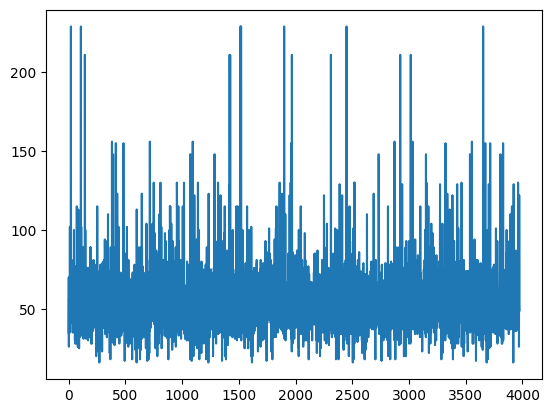

In [8]:
import matplotlib.pyplot as plt
plt.plot(train['Question'].apply(lambda x: len(x)))
# plt.plot(train['Response'].apply(lambda x: len(x) if isinstance(x, str) else 1))

In [9]:
# plt.plot(train['Response'].apply(lambda x: len(x) if isinstance(x, str) else 1))

In [10]:
gkf = StratifiedGroupKFold(n_splits=CFG.n_fold,shuffle=True,random_state=CFG.seed)

for i, (_, val_index) in enumerate(gkf.split(train, train["target"],groups=train['Question'])):
    train.loc[val_index, "fold"] = i
train['index'] = train.index
test['index'] = test.index

train.head()

,Question,Response,target,fold,index
0,Explain the concept of coevolution.,Coevolution is a biological process that occur...,3,0.0,0
1,Is it possible that recurring fever and chills...,"Yes, recurring fever and chills can be a sympt...",4,4.0,1
2,Evaluate the expression 3!,The expression 3! represents the factorial of ...,1,2.0,2
3,What are the roles of different types of RNA i...,1. Messenger RNA (mRNA): mRNA carries genetic ...,3,2.0,3
4,What is the role of gene flow in population ge...,Gene flow refers to the movement of individual...,3,3.0,4


In [11]:
# train['all_text'] = "[QUESTION_START]"+" "+train['Question']+" "+"[QUESTION_END]"+" "+"[RESPONSE_START]"+" "+train['Response']+" "+"[RESPONSE_END]"
# test['all_text'] = "[QUESTION_START]"+" "+test['Question']+" "+"[QUESTION_END]"+" "+"[RESPONSE_START]"+" "+test['Response']+" "+"[RESPONSE_END]"

In [12]:
def _prepare_training_data_helper(df, is_train):
    tok = CFG.tokenizer.encode(df['all_text'].values[0],
                               add_special_tokens=False, max_length=CFG.max_len)
    if is_train:
        label = df[true_cols].values[0]
        return {'input_ids': tok, 'label': label}
    else:
        return {'input_ids': tok}

def prepare_training_data(df, tokenizer, num_jobs, is_train):
    
    results = Parallel()(
        delayed(_prepare_training_data_helper)(gdf, is_train) for gn, gdf in tqdm(df.groupby('index'))
    )
    
    return results


In [13]:
# NUM_JOBS = os.cpu_count()
# train_processed = prepare_training_data(train, CFG.tokenizer, num_jobs=NUM_JOBS, is_train=True)

In [14]:
train.head()

,Question,Response,target,fold,index
0,Explain the concept of coevolution.,Coevolution is a biological process that occur...,3,0.0,0
1,Is it possible that recurring fever and chills...,"Yes, recurring fever and chills can be a sympt...",4,4.0,1
2,Evaluate the expression 3!,The expression 3! represents the factorial of ...,1,2.0,2
3,What are the roles of different types of RNA i...,1. Messenger RNA (mRNA): mRNA carries genetic ...,3,2.0,3
4,What is the role of gene flow in population ge...,Gene flow refers to the movement of individual...,3,3.0,4


In [15]:
class H2OLLMDataset(Dataset):
    def __init__(self, df, train):
        self.df = df
        self.train = train
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        row = self.df.iloc[idx]
        if self.train:
            targets = row['target']
        input_text = row.Question+ CFG.seperator + str(row.Response)
        tokenized_dict = CFG.tokenizer(input_text, add_special_tokens = True)
        input_ids = tokenized_dict.input_ids
        attention_mask = tokenized_dict.attention_mask
        head_mask = []
        use_full = False
        for token in tokenized_dict.input_ids:
            if token == CFG.tokenizer.sep_token_id:
                use_full = not use_full 
            head_mask.append(1 if use_full else .0)
            
#         print(head_mask)      
        if self.train:
            return {'ids':input_ids,'mask':attention_mask, 'targets':targets,'head_mask':head_mask}        
        else:
            return {'ids':input_ids,'mask':attention_mask, 'head_mask':head_mask}        

class Collate:
    def __init__(self, cfg, train):
        self.tokenizer = cfg.tokenizer
        self.cfg = cfg
        self.train = train

    def __call__(self, batch):
        output = dict()
        output["ids"] = [sample["ids"] for sample in batch]
        output["mask"] = [sample["mask"] for sample in batch]
        output["head_mask"] = [sample["head_mask"] for sample in batch]
        if self.train:
            output["targets"] = [sample["targets"] for sample in batch]
            
        # calculate max token length of this batch
        batch_max = max([len(ids) for ids in output["ids"]])
        batch_max = min(batch_max, CFG.train_max_len if self.train else CFG.test_max_len)
        
        output["ids"] = [s[:batch_max] for s in output["ids"]]
        output["mask"] = [s[:batch_max] for s in output["mask"]]
        output["head_mask"] = [s[:batch_max] for s in output["head_mask"]]

        output["ids"] = [s + (batch_max - len(s)) * [self.tokenizer.pad_token_id] for s in output["ids"]]        
        output["mask"] = [s + (batch_max - len(s)) * [0] for s in output["mask"]]     
        output["head_mask"] = [s + (batch_max - len(s)) * [0] for s in output["head_mask"]]       
              
        # convert to tensors
        output["ids"] = torch.tensor(output["ids"], dtype=torch.long)
        output["mask"] = torch.tensor(output["mask"], dtype=torch.long)
        output["head_mask"] = torch.tensor(output["head_mask"], dtype=torch.float)        
        if self.train:
            output["targets"] = torch.tensor(output["targets"], dtype=torch.long)
   
        return output

In [16]:
class WeightedLayerPooling(nn.Module):
    def __init__(self, layers = 12):
        super(WeightedLayerPooling, self).__init__()
        self.layers = layers
        self.layer_weights = nn.Parameter(
                torch.tensor([1] * layers, dtype=torch.float)
            )

    def forward(self, all_hidden_states):
        all_hidden_states = torch.stack(all_hidden_states, dim=0)
        all_layer_embedding = all_hidden_states[-self.layers:, :, :, :]
        weight_factor = self.layer_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(all_layer_embedding.size())
        weighted_average = (weight_factor*all_layer_embedding).sum(dim=0) / self.layer_weights.sum()
        return weighted_average
    
class MeanPooling(nn.Module):
    def __init__(self, clamp_min=1e-9): 
        super(MeanPooling, self).__init__()
        self.clamp_min = clamp_min
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=self.clamp_min) 
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings    
    
    
class Multisample_Dropout(nn.Module):
    def __init__(self):
        super(Multisample_Dropout, self).__init__()
        self.dropout = nn.Dropout(.1)
        self.dropouts = nn.ModuleList([nn.Dropout((i+1)*.1) for i in range(5)])
        
    def forward(self, x, module):
        x = self.dropout(x)
        return torch.mean(torch.stack([module(dropout(x)) for dropout in self.dropouts],dim=0),dim=0)    

In [17]:
class Head(nn.Module):
    def __init__(self,hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.cat_size = hidden_size*2

        self.layer_pooler = WeightedLayerPooling(6) 
        self.sequence_pooler = MeanPooling(.0) 
        #self.rnn = utilities.Bi_RNN_FOUT(self.cat_size self.cat_size//2)   

        self.head = nn.Sequential(nn.Linear(self.hidden_size,CFG.num_labels)) 
#         self.aux_head = nn.Sequential(nn.Linear(self.hidden_size len(CFG.aux_classes))) 

        self.dropout = Multisample_Dropout()
                                    
    def forward(self,x,mask): 

        x = self.layer_pooler(x.hidden_states) 
        x = self.sequence_pooler(x,mask) 
        x_preds = self.dropout(x,self.head) 
        return x_preds
            
    def process_outputs(self,out):
        n_layers = int(len(out)/2)
        out = torch.stack(out[-n_layers:],dim=0) 
        out_mean = torch.mean(out,dim=0)
        out_max,_ = torch.max(out,dim=0)
        out_std = torch.std(out,dim=0)
        last_hidden_states = torch.cat((out_mean,out_max,out_std), dim=-1)
        return last_hidden_states

In [18]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.config = AutoConfig.from_pretrained(
            CFG.model,
            output_hidden_states=True,
            hidden_dropout_prob=.0,
            attention_probs_dropout_prob=.0,
            num_hidden_layers=CFG.num_hidden_layers,
        )
        
        
        self.transformer = AutoModel.from_pretrained(
            CFG.model,
            config=self.config,
        )
        
        self.transformer.resize_token_embeddings(len(CFG.tokenizer))

        self.transformer.gradient_checkpointing_enable()
        self.head = Head(self.config.hidden_size)

    def forward(self, input_ids, attention_mask, head_mask):
        x = self.transformer(input_ids, attention_mask = attention_mask)
        x = self.head(x, head_mask)
        return x

    def get_parameters(self):

        parameter_settings = []
        parameter_settings.extend(self.get_parameter_section([(n, p) for n, p in self.transformer.named_parameters()], lr=CFG.backbone_lr, wd=CFG.backbone_weight_decay, freeze=CFG.freeze))
        parameter_settings.extend(self.get_parameter_section([(n, p) for n, p in self.head.named_parameters()], lr=CFG.head_lr, wd=CFG.head_weight_decay))
        return parameter_settings

    def get_parameter_section(self, parameters, lr=None, wd=None, freeze=None): 
        parameter_settings = []
        freeze_layers = ['LayerNorm']
        lr_is_dict = isinstance(lr, dict)
        wd_is_dict = isinstance(wd, dict)
        layer_no = None
        for no, (n,p) in enumerate(parameters):
            for split in n.split('.'):
                if split.isnumeric():
                    layer_no = int(split)
            if not layer_no:
                layer_no = 0

            if freeze and layer_no < freeze:
                p.requires_grad = False
            if lr_is_dict:
                for k,v in lr.items():
                    if layer_no < int(k):
                        temp_lr = v
                        break
            else:
                temp_lr = lr

            if wd_is_dict:
                for k,v in wd.items():
                    if layer_no < int(k):
                        temp_wd = v
                        break
            else:
                temp_wd = wd
            weight_decay = 0.0 if 'bias' in n else temp_wd
            parameter_setting = {'params' : p, 'lr' : temp_lr, 'weight_decay' : temp_wd}
            parameter_settings.append(parameter_setting)
        return parameter_settings

In [19]:
# ### https://www.kaggle.com/datasets/shohei105/deberta-v3-base-attention-fold10-1024?select=model.py
# class CLSPooling(nn.Module):
#     def __init__(self, in_features) -> None:
#         super().__init__()
#         self.layer_norm = nn.LayerNorm(in_features)
#         self.out_size = in_features

#     def forward(self, last_hidden_state, hidden_states, attention_mask):
#         return self.layer_norm(last_hidden_state[:, 0, :])


# class CLSConcatPooling(nn.Module):
#     def __init__(self, in_features, num_hidden_layers) -> None:
#         super().__init__()
#         self.num_hidden_layers = num_hidden_layers
#         self.layer_norm = nn.LayerNorm(in_features * num_hidden_layers)
#         self.out_size = in_features * num_hidden_layers

#     def forward(self, last_hidden_state, hidden_states, attention_mask):
#         x = torch.cat([hidden_states[-(i + 1)][:, 0, :] for i in range(self.num_hidden_layers)], dim=1)
#         x = self.layer_norm(x)
#         return x


# class MeanPooling(nn.Module):
#     def __init__(self, in_features) -> None:
#         super().__init__()
#         self.layer_norm = nn.LayerNorm(in_features)
#         self.out_size = in_features

#     def forward(self, last_hidden_state, hidden_states, attention_mask):
#         input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
#         sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
#         sum_mask = input_mask_expanded.sum(1)
#         sum_mask = torch.clamp(sum_mask, min=1e-9)
#         mean_embeddings = sum_embeddings / sum_mask
#         norm_mean_embeddings = self.layer_norm(mean_embeddings)
#         return norm_mean_embeddings


# class MaxPooling(nn.Module):
#     def __init__(self, in_features) -> None:
#         super().__init__()
#         self.layer_norm = nn.LayerNorm(in_features)
#         self.out_size = in_features

#     def forward(self, last_hidden_state, hidden_states, attention_mask):
#         max_embeddings, _ = torch.max(last_hidden_state, 1)
#         norm_max_embeddings = self.layer_norm(max_embeddings)
#         return norm_max_embeddings


# class MeanMaxConcatPooling(nn.Module):
#     def __init__(self, in_features) -> None:
#         super().__init__()
#         self.layer_norm_mean = nn.LayerNorm(in_features)
#         self.layer_norm_max = nn.LayerNorm(in_features)
#         self.out_size = in_features * 2

#     def forward(self, last_hidden_state, hidden_states, attention_mask):
#         input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
#         sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
#         sum_mask = input_mask_expanded.sum(1)
#         sum_mask = torch.clamp(sum_mask, min=1e-9)
#         mean_embeddings = sum_embeddings / sum_mask
#         norm_mean_embeddings = self.layer_norm_mean(mean_embeddings)

#         max_embeddings, _ = torch.max(last_hidden_state, 1)
#         norm_max_embeddings = self.layer_norm_max(max_embeddings)
#         norm_mean_max_embeddings = torch.cat(
#             (
#                 norm_mean_embeddings,
#                 norm_max_embeddings,
#             ),
#             1,
#         )

#         return norm_mean_max_embeddings


# class AttentionPooling(nn.Module):
#     def __init__(self, in_features) -> None:
#         super().__init__()
#         self.attention = nn.Sequential(
#             nn.Linear(in_features, in_features),
#             nn.LayerNorm(in_features),
#             nn.GELU(),
#             nn.Linear(in_features, 1),
#         )
#         self.out_size = in_features

#     def forward(self, last_hidden_state, hidden_states, attention_mask):
#         w = self.attention(last_hidden_state).float()
#         w[attention_mask == 0] = float("-inf")
#         w = torch.softmax(w, 1)
#         output = torch.sum(w * last_hidden_state, dim=1)
#         return output


# # class WeightedLayerPooling(nn.Module):
# #     def __init__(self, in_features, num_hidden_layers, weights) -> None:
# #         super().__init__()
# #         self.num_hidden_layers = num_hidden_layers
# #         self.layer_weights = (
# #             nn.Parameter(torch.tensor(weights, dtype=torch.float))
# #             if weights is not None
# #             else nn.Parameter(torch.tensor([1] * num_hidden_layers, dtype=torch.float))
# #         )
# #         self.layer_norm = nn.LayerNorm(in_features)
# #         self.out_size = in_features

# #     def forward(self, last_hidden_state, hidden_states, attention_mask):
# #         all_layer_embedding = torch.stack(hidden_states)
# #         all_layer_embedding = all_layer_embedding[-self.num_hidden_layers :, :, :, :]

# #         weight_factor = self.layer_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(all_layer_embedding.size())
# #         weighted_average = (weight_factor * all_layer_embedding).sum(dim=0) / self.layer_weights.sum()

# #         input_mask_expanded = attention_mask.unsqueeze(-1).expand(weighted_average.size()).float()
# #         sum_embeddings = torch.sum(weighted_average * input_mask_expanded, 1)
# #         sum_mask = input_mask_expanded.sum(1)
# #         sum_mask = torch.clamp(sum_mask, min=1e-9)
# #         mean_embeddings = sum_embeddings / sum_mask
# #         norm_mean_embeddings = self.layer_norm(mean_embeddings)

# #         return norm_mean_embeddings


# class LSTMPooling(nn.Module):
#     def __init__(self, in_features, dropout) -> None:
#         super().__init__()
#         self.lstm = nn.LSTM(
#             input_size=in_features,
#             hidden_size=in_features,
#             batch_first=True,
#             bidirectional=True,
#             dropout=dropout,
#         )
#         self.layer_norm = nn.LayerNorm(in_features * 2)
#         self.out_size = in_features * 2

#     def forward(self, last_hidden_state, hidden_states, attention_mask):
#         output, (h, c) = self.lstm(last_hidden_state, None)
#         return self.layer_norm(torch.cat([h[0], h[1]], dim=1))


# class GRUPooling(nn.Module):
#     def __init__(self, in_features, dropout) -> None:
#         super().__init__()
#         self.gru = nn.GRU(
#             input_size=in_features,
#             hidden_size=in_features,
#             batch_first=True,
#             bidirectional=True,
#             dropout=dropout,
#         )
#         self.layer_norm = nn.LayerNorm(in_features * 2)
#         self.out_size = in_features * 2

#     def forward(self, last_hidden_state, hidden_states, attention_mask):
#         output, h = self.gru(last_hidden_state, None)
#         return self.layer_norm(torch.cat([h[0], h[1]], dim=1))


In [20]:
from datasets.features.features import config

class AWP:
    def __init__(
        self,
        model,
        optimizer,
        adv_param = 'weight',
        adv_lr = 1,
        adv_eps = 0.2,
        start_step = 0,
        adv_step = 1,
        scaler = None
    ):
        self.model = model
        self.optimizer = optimizer
        self.adv_param = adv_param
        self.adv_lr = adv_lr
        self.adv_eps = adv_eps
        self.start_step = start_step
        self.adv_step = adv_step
        self.backup = {}
        self.backup_eps = {}
        self.scaler = scaler

    def attack_backward(self, batch, epoch):
        
        criterion = Loss_Fn()
        
        if (self.adv_lr == 0) or (epoch < self.start_step):
            return None

        self._save()
        for i in range(self.adv_step):
            self._attack_step() 
            with autocast(enabled = CFG.apex):
                input_ids = batch['ids'].to(CFG.device)
                attention_mask = batch['mask'].to(CFG.device)
                # token_type_ids = batch['token_type_ids'].to(cfg.device)
                labels = batch['targets'].to(CFG.device)
                tr_logits = self.model(input_ids, attention_mask,  labels)
                
                loss = criterion(tr_logits, labels)
                adv_loss = loss
                if CFG.gradient_accumulation_steps > 1:
                    adv_loss = loss / CFG.gradient_accumulation_steps
                    
#                 adv_loss = adv_loss.mean()
            self.optimizer.zero_grad()
            self.scaler.scale(adv_loss).backward()
            
        self._restore()

    def _attack_step(self):
        e = 1e-6
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                norm1 = torch.norm(param.grad)
                norm2 = torch.norm(param.data.detach())
                if norm1 != 0 and not torch.isnan(norm1):
                    r_at = self.adv_lr * param.grad / (norm1 + e) * (norm2 + e)
                    param.data.add_(r_at)
                    param.data = torch.min(
                        torch.max(param.data, self.backup_eps[name][0]), self.backup_eps[name][1]
                    )
                    
    def _save(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                if name not in self.backup:
                    self.backup[name] = param.data.clone()
                    grad_eps = self.adv_eps * param.abs().detach()
                    self.backup_eps[name] = (
                        self.backup[name] - grad_eps,
                        self.backup[name] + grad_eps,
                    )

    def _restore(self,):
        for name, param in self.model.named_parameters():
            if name in self.backup:
                param.data = self.backup[name]
        self.backup = {}
        self.backup_eps = {}

In [21]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

def get_score(outputs,targets): #outputs=preds, targets=groundtruth
    mcrmse = []
    for i in range(CFG.num_labels):
        mcrmse.append(
            metrics.mean_squared_error(
                targets[:, i],
                outputs[:, i],
                squared=False,
            ),
        )
    mcrmse = np.mean(mcrmse)
    return mcrmse

In [22]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, 
             valid_loader=None, valid_idx=None,test_loader=None, best_score=np.inf):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    # best_score = np.inf


    if CFG.use_awp:
        # Initialize AWP
        log_awp=True
        awp = AWP(model, optimizer, adv_lr = CFG.adv_lr, adv_eps = CFG.adv_eps, 
                  start_step = CFG.start_awp_epoch, scaler = scaler)


    for step, inputs in enumerate(train_loader):
        model.train()
        gc.collect()

        inputs['ids'] = inputs['ids'].to(device)
        inputs['mask'] = inputs['mask'].to(device)
        inputs['head_mask'] = inputs['head_mask'].to(device)
        labels = inputs['targets'].to(device)
        
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs['ids'],inputs['mask'],inputs['head_mask'])
            loss = criterion(y_preds, labels.reshape(-1)) #.view(-1, 1))
            
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
                
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        if CFG.use_awp and best_score <= CFG.awp_score_check:
            if best_score <= CFG.awp_score_check and log_awp:
                LOGGER.info(' Start AWP '.center(50, '-'))
                log_awp=False
            if (step + 1) % CFG.gradient_accumulation_steps == 0:
                awp.attack_backward(inputs, epoch)
        

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
        
        if CFG.val_strategy=="batch": 
            if step % CFG.val_steps == 0 or step == (len(train_loader)-1): # or if last step 
                avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device, valid_idx)
                test_preds = test_fn(test_loader, model, device)
                valid_df = train[train.index.isin(valid_idx)].copy()
                
                for i,c in enumerate(pred_cols):
                    valid_df.loc[:, f'{c}'] = predictions[:,i] #valid_df['index'].apply(lambda x: output_map[x][i])
                
                valid_labels = valid_df[true_cols].values
                valid_preds = valid_df[pred_cols].values

                score = log_loss(valid_labels,valid_preds)
                save_preds = valid_df[pred_cols].values
                print(f"Score:{score}")
                if  score < best_score:
                    best_score = score
                    print(f'Epoch {epoch+1} - Step {step}/{len(train_loader)} - Save Best Score: {best_score:.4f} Model')
                    LOGGER.info(f'Epoch {epoch+1} - Step {step}/{len(train_loader)} - Save Best Score: {best_score:.4f} Model')                    
                    torch.save({'model': model.state_dict(),
                                'predictions': save_preds,
                                 'test_preds':test_preds},
                               OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
                        
    return losses.avg, best_score


def valid_fn(valid_loader, model, criterion, device, valid_idx):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, inputs in enumerate(valid_loader):
        inputs['ids'] = inputs['ids'].to(device)
        inputs['mask'] = inputs['mask'].to(device)
        inputs['head_mask'] = inputs['head_mask'].to(device)

        labels = inputs['targets'].to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs['ids'],inputs['mask'],inputs['head_mask'])
            loss = criterion(y_preds, labels.reshape(-1)) #.view(-1, 1))
            
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        losses.update(loss.item(), batch_size)
        y_preds_sm = F.softmax(y_preds,1)
        preds.append(y_preds_sm.detach().to('cpu').numpy())

        end = time.time()
        if step == (len(valid_loader)-1): #print only at the end 
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
        
    preds = np.vstack(preds) 
    
    return losses.avg, preds 

def test_fn(test_loader, model, device):
    model.eval()
    preds = []
    
    for step, inputs in enumerate(test_loader):
        inputs['ids'] = inputs['ids'].to(device)
        inputs['mask'] = inputs['mask'].to(device)
        inputs['head_mask'] = inputs['head_mask'].to(device)

        with torch.no_grad():
            y_preds = model(inputs['ids'],inputs['mask'],inputs['head_mask'])
            
        y_preds_sm = F.softmax(y_preds,1)
        preds.append(y_preds_sm.detach().to('cpu').numpy())

    preds = np.vstack(preds) 
    
    return preds

In [23]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
     
    seed_everything(seed=CFG.seed)

    print(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_df = train[train["fold"] != fold].reset_index(drop=True)
    valid_df = train[train["fold"] == fold].reset_index(drop=True)
    test_df = test.reset_index(drop=True)
    
    NUM_JOBS = os.cpu_count()
    # ====================================================
    model = Model()
#     torch.save(model.model_config, OUTPUT_DIR+'config.pth')
    model.to(device)

    if CFG.wandb: # this logs all gradients
        wandb.watch(model, log='all')
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
              'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
              'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
              'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

#     optimizer_parameters = get_optimizer_params(model,
#                                                 encoder_lr=CFG.encoder_lr, 
#                                                 decoder_lr=CFG.decoder_lr,
#                                                 weight_decay=CFG.weight_decay)
    
    if CFG.gpu_optimize_config_adam:
        optimizer = bnb.optim.AdamW(optimizer_parameters, lr=CFG.encoder_lr, optim_bits=8)
    else:
        optimizer = AdamW(model.get_parameters(), eps=1e-6)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, 
                num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_df) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    # criterion = nn.BCEWithLogitsLoss(reduction="mean")
    criterion = nn.CrossEntropyLoss()
#     criterion = Loss_Fn() #MSECorrLoss()
    
    best_score = np.inf
#     orig_len = CFG.max_len
    for epoch in range(CFG.epochs):
#         if epoch==0:
#             CFG.max_len = 512
#         if epoch==1:
#             CFG.max_len = 512
#         if epoch==2:
#             CFG.max_len = 512 
#         else:
#             CFG.max_len = 512
        
#         CFG.max_len = orig_len
#         training_samples_ = prepare_training_data(train_df, CFG.tokenizer, num_jobs=NUM_JOBS, is_train=True)
        
#         CFG.max_len = 768 
#         valid_samples_ = prepare_training_data(valid_df, CFG.tokenizer, num_jobs=NUM_JOBS, is_train=True)
#         test_samples = prepare_training_data(test_df, CFG.tokenizer, num_jobs=NUM_JOBS, is_train=False)
        
#         training_samples, valid_samples = training_samples_, valid_samples_

        valid_idx = valid_df['index'].tolist()
#         for x in valid_df:
#             valid_idx.append(x['index'])  

        print(valid_df.shape)

        train_dataset = H2OLLMDataset(train_df,train=True)
        valid_dataset = H2OLLMDataset(valid_df,train=True)
        test_dataset = H2OLLMDataset(test_df,train=False)
        
        collate_fn_train = Collate(CFG,train=True)
        collate_fn_test = Collate(CFG,train=False)

        train_loader = DataLoader(train_dataset,
                                  batch_size=CFG.batch_size,
                                  shuffle=True,
                                  collate_fn=collate_fn_train, 
                                  num_workers=CFG.num_workers, 
                                  pin_memory=True,
                                  drop_last=True)
        valid_loader = DataLoader(valid_dataset,
                                  batch_size=CFG.batch_size,
                                  shuffle=False, 
                                  collate_fn=collate_fn_train, 
                                  num_workers=CFG.num_workers, 
                                  pin_memory=True,
                                  drop_last=False)
        test_loader = DataLoader(test_dataset,
                                  batch_size=CFG.batch_size,
                                  shuffle=False, 
                                  collate_fn=collate_fn_test, 
                                  num_workers=CFG.num_workers, 
                                  pin_memory=True,
                                  drop_last=False)        
        start_time = time.time()

        # train and validate
        avg_loss, best_score = train_fn(fold, train_loader, model, criterion, 
                                        optimizer, epoch, scheduler, device, 
                                        valid_loader, valid_idx, test_loader,best_score)

    
    tmp = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))
    predictions = tmp['predictions']
    test_preds = tmp['test_preds']
    
    for i in range(predictions.shape[1]):
        valid_df[f'{pred_cols[i]}'] = predictions[:,i]

    for i in range(test_preds.shape[1]):
        test_df[f'{pred_cols[i]}'] = test_preds[:,i]
        
    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_df,test_df

In [24]:
# if __name__ == '__main__':
    
def get_result(oof_df):
    labels = oof_df[true_cols].values
    preds = oof_df[pred_cols].values
#         score = get_score(labels, preds)
    score = log_loss(labels,preds)
    print(f'Full Fold Score: {score:<.4f}')

if CFG.train:
    oof_df = pd.DataFrame()
    for fold in range(CFG.n_fold):
        if fold in CFG.trn_fold:
            _oof_df,_test_df = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            _oof_df.to_csv(OUTPUT_DIR+f'oof_df{fold}.csv',index=False)
            _test_df.to_csv(OUTPUT_DIR+f'test_df{fold}.csv',index=False)                
            print(f"========== fold: {fold} result ==========")
            get_result(_oof_df)
            
    oof_df = oof_df.reset_index(drop=True)
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
    oof_df.to_csv(OUTPUT_DIR+'oof_df.csv',index=False)

if CFG.wandb:
    wandb.finish()

========== fold: 0 training ==========
(798, 5)
Epoch: [1][0/397] Elapsed 0m 1s (remain 12m 37s) Loss: 1.9132(1.9132) Grad: inf  LR: 0.00000002  
EVAL: [99/100] Elapsed 0m 16s (remain 0m 0s) Loss: 2.1178(1.9900) 
Score:1.9900147314891061
Epoch 1 - Step 0/397 - Save Best Score: 1.9900 Model
Epoch: [1][100/397] Elapsed 1m 21s (remain 3m 57s) Loss: 1.7048(1.8344) Grad: 42994.0664  LR: 0.00000200  
Epoch: [1][200/397] Elapsed 2m 2s (remain 1m 59s) Loss: 1.9555(1.7494) Grad: 157095.4844  LR: 0.00000199  
EVAL: [99/100] Elapsed 0m 16s (remain 0m 0s) Loss: 0.7419(1.3131) 
Score:1.3130609127703534
Epoch 1 - Step 250/397 - Save Best Score: 1.3131 Model
Epoch: [1][300/397] Elapsed 3m 24s (remain 1m 5s) Loss: 1.5892(1.6475) Grad: 98818.7891  LR: 0.00000194  
Epoch: [1][396/397] Elapsed 4m 2s (remain 0m 0s) Loss: 1.7603(1.5956) Grad: 48055.5156  LR: 0.00000188  
EVAL: [99/100] Elapsed 0m 16s (remain 0m 0s) Loss: 0.4764(1.2383) 
Score:1.2382805159558103
Epoch 1 - Step 396/397 - Save Best Score: 1.2

Score:1.2037244640940714
Epoch: [5][100/397] Elapsed 1m 14s (remain 3m 39s) Loss: 0.0969(0.2065) Grad: 39531.9297  LR: 0.00000012  
Epoch: [5][200/397] Elapsed 1m 56s (remain 1m 53s) Loss: 0.0042(0.1829) Grad: 2233.0999  LR: 0.00000005  
EVAL: [99/100] Elapsed 0m 15s (remain 0m 0s) Loss: 0.5429(1.3326) 
Score:1.3326471691676953
Epoch: [5][300/397] Elapsed 3m 13s (remain 1m 1s) Loss: 0.0083(0.1745) Grad: 6019.8291  LR: 0.00000001  
Epoch: [5][396/397] Elapsed 3m 53s (remain 0m 0s) Loss: 0.0256(0.1674) Grad: 20470.0586  LR: 0.00000000  
EVAL: [99/100] Elapsed 0m 15s (remain 0m 0s) Loss: 0.4965(1.3529) 
Score:1.35285369090407
========== fold: 1 result ==========
Full Fold Score: 1.0513
========== fold: 2 training ==========
(798, 5)
Epoch: [1][0/397] Elapsed 0m 0s (remain 5m 34s) Loss: 1.8809(1.8809) Grad: inf  LR: 0.00000002  
EVAL: [99/100] Elapsed 0m 16s (remain 0m 0s) Loss: 1.9605(1.9863) 
Score:1.9863337348105596
Epoch 1 - Step 0/397 - Save Best Score: 1.9863 Model
Epoch: [1][100/397

Epoch: [4][200/398] Elapsed 1m 59s (remain 1m 56s) Loss: 0.2971(0.3770) Grad: 183895.0000  LR: 0.00000045  
EVAL: [98/99] Elapsed 0m 15s (remain 0m 0s) Loss: 1.3661(1.2858) 
Score:1.2858393909294372
Epoch: [4][300/398] Elapsed 3m 15s (remain 1m 2s) Loss: 0.0104(0.3561) Grad: 11682.0605  LR: 0.00000032  
Epoch: [4][397/398] Elapsed 3m 54s (remain 0m 0s) Loss: 0.1815(0.3546) Grad: 71147.2266  LR: 0.00000021  
EVAL: [98/99] Elapsed 0m 15s (remain 0m 0s) Loss: 1.5530(1.2774) 
Score:1.2774053882727345
(791, 5)
Epoch: [5][0/398] Elapsed 0m 1s (remain 6m 53s) Loss: 0.0623(0.0623) Grad: 172724.6094  LR: 0.00000021  
EVAL: [98/99] Elapsed 0m 15s (remain 0m 0s) Loss: 1.5545(1.2779) 
Score:1.2779292127868924
Epoch: [5][100/398] Elapsed 1m 17s (remain 3m 48s) Loss: 0.4406(0.1852) Grad: 824701.4375  LR: 0.00000012  
Epoch: [5][200/398] Elapsed 1m 55s (remain 1m 53s) Loss: 0.0050(0.1871) Grad: 3021.7805  LR: 0.00000005  
EVAL: [98/99] Elapsed 0m 15s (remain 0m 0s) Loss: 1.5804(1.3268) 
Score:1.32679

In [25]:
oof_df.head()

,Question,Response,target,fold,index,target_0,target_1,target_2,target_3,target_4,target_5,target_6
0,Explain the concept of coevolution.,Coevolution is a biological process that occur...,3,0.0,0,0.022390,0.017767,0.454262,0.411248,0.009236,0.003725,0.081372
1,"People buy me to eat, but never eat me. What a...",It's anagrams! [PARAGRAPH] The letters in the ...,5,0.0,8,0.226670,0.070952,0.541456,0.051460,0.042874,0.027054,0.039533
2,What were the consequences of the Opium Wars?,The Opium Wars (1839-1842 and 1856-1860) had s...,4,0.0,16,0.280868,0.000429,0.257425,0.000537,0.457470,0.000242,0.003029
3,Can you recommend a list of must-watch televis...,"As an AI language model developed by OpenAI, I...",3,0.0,22,0.000038,0.001531,0.000346,0.996550,0.000069,0.000721,0.000745
4,Which film features a character named Miranda ...,The film featuring a character named Miranda P...,2,0.0,25,0.137045,0.036703,0.365976,0.018711,0.375107,0.000742,0.065716


In [26]:
CFG.tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')

('///mnt/c/Personal/Competitions/Kaggle/h2oai-predict-the-llm/runs/nb003/tokenizer/tokenizer_config.json',
 '///mnt/c/Personal/Competitions/Kaggle/h2oai-predict-the-llm/runs/nb003/tokenizer/special_tokens_map.json',
 '///mnt/c/Personal/Competitions/Kaggle/h2oai-predict-the-llm/runs/nb003/tokenizer/spm.model',
 '///mnt/c/Personal/Competitions/Kaggle/h2oai-predict-the-llm/runs/nb003/tokenizer/added_tokens.json',
 '///mnt/c/Personal/Competitions/Kaggle/h2oai-predict-the-llm/runs/nb003/tokenizer/tokenizer.json')

In [27]:
sample_submission.head()

,id,target_0,target_1,target_2,target_3,target_4,target_5,target_6
0,0,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
1,1,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
2,2,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
3,3,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
4,4,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857


In [28]:
def make_subs(sub_dir=OUTPUT_DIR):
    out = []
    for n,flds in tqdm(enumerate(CFG.trn_fold)):
        fname = os.path.join(sub_dir,f'test_df{flds}.csv')
        f = pd.read_csv(fname)
        if n == 0:
            cols = ['id']+pred_cols
        else:
            cols = pred_cols
        out_ = f[cols]
        out.append(out_)
    out = pd.concat(out,axis=1)
    res = pd.DataFrame()
    res['id'] = out['id']
    for c in pred_cols:
        res[c] = out[c].mean(1)
        
    return res

sub = make_subs()
sub.to_csv(os.path.join(OUTPUT_DIR,f'submit_{CFG.EXP_NAME}.csv'),index=False)

5it [00:00, 80.63it/s]
